In [3]:
# Load all the required Modules

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import model_selection, svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import random
import pickle
#from lesson_functions import *
from sklearn import __version__ as sklearn_version

# if (float(sklearn_version[:4]) >= 0.18):
#     print("sklearn_version:",sklearn_version)
from sklearn.model_selection import train_test_split
# else :
#from sklearn.cross_validation import train_test_split
    
%matplotlib inline

print("Modules Successfully Loaded!!!")

Modules Successfully Loaded!!!


In [4]:
#### All the required Helper Functions

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

#### Define a function to return HOG features with/without visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, block_norm='L2-Hys',
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, block_norm='L2-Hys', 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        #print("Defined Function - get_hog_features")
        return features


##### Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    #print("Defined Function - bin_spatial")
    return features


##### Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):   #, bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)  #, range=bins_range
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)  #, range=bins_range
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)  #, range=bins_range
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #print("Defined Function - color_hist")
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

##### Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        #print("len file_features:", len(file_features))    
        features.append(np.concatenate(file_features))
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    #print("Defined Function - extract_features")
    return features
    

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    #print("Defined Function - slide_window")
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    #print("Defined Function - draw_boxes")
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    #print("Defined Function - single_img_features")
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    #print("Defined Function - search_windows")
    return on_windows


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #print("Find Cars")
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # An array to store detection boxes (Bonding Boxes)
    detections = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #print("ctrans_tosearch size:", ctrans_tosearch.shape)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
             
            test_prediction = svc.predict(test_features)
            #print("test_prediction:", test_prediction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                position = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                #print("position", position)
                
                detections.append(position)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return detections

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    #print("Defined Function - add_heat")   
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    #print("Defined Function - apply_threshold for Heatmap") 
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    #print("Defined Function - draw_labeled_bboxes")
    return img


In [5]:
#### Function to Read the Vehicle and non-Vehicle Images

import os
import glob

t=time.time()

#### Locate and read the Vehicle images
basedir = 'vehicles/'

img_dirs = os.listdir(basedir)
cars = []

for img_dir in img_dirs :
    cars.extend(glob.glob(basedir+img_dir+'/*'))
    
print("Total # of Car Images Found:", len(cars))

with open("car.txt", 'w') as f:
    for i in cars :
        f.write(i+'\n')
        
        
##### Locate and read the Non-Vehicle images
basedir2 = 'non-vehicles/'

img_dirs2 = os.listdir(basedir2)
notcars = []

for img_dir2 in img_dirs2 :
    notcars.extend(glob.glob(basedir2+img_dir2+'/*'))
    
print("Total # of Non-Car Images Found:", len(notcars))

with open("notcar.txt", 'w') as f:
    for i in notcars :
        f.write(i+'\n') 

        
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Load car and non-car training Images...')



Total # of Car Images Found: 1196
Total # of Non-Car Images Found: 1125
0.03 Seconds to Load car and non-car training Images...


In [36]:
#print(cars)

In [6]:
car_imgNames = [line.rstrip() for line in open('car.txt')]
nocar_imgNames = [line.rstrip() for line in open('notcar.txt')]

print ("cars:", len(car_imgNames))
print ("NOT cars:", len(nocar_imgNames))


cars: 1196
NOT cars: 1125


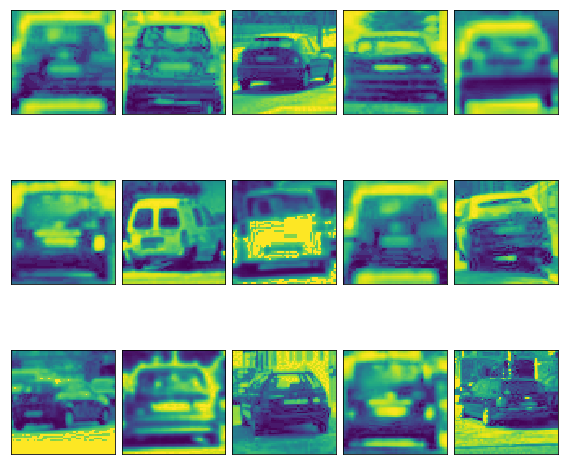

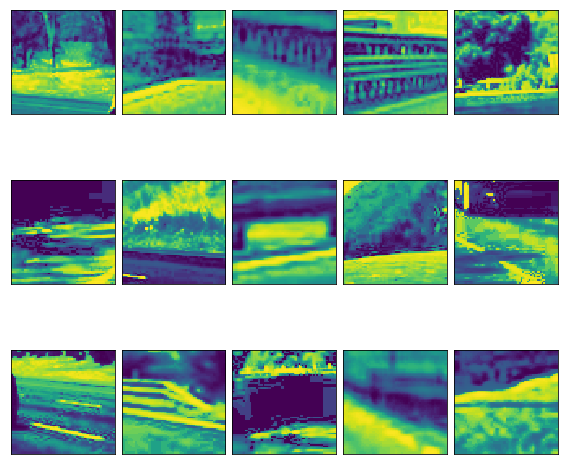

In [7]:
#Let's visualize the training set. After all the trial and error methods in lab exerices, 
#I will be using YCrCb color space for training.

# Visualize Cars
x = random.sample(range(1, len(car_imgNames)), 15)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(3,5,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    #axis.imshow(mpimg.imread(car_imgNames[x[i]]))
    axis.imshow(cv2.equalizeHist(cv2.imread(car_imgNames[x[i]], 0)))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('carvisualize.jpg')
plt.show()


# Visualize Non-Cars
x = random.sample(range(1, len(nocar_imgNames)), 15)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(3,5,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    #axis.imshow(mpimg.imread(nocar_imgNames[x[i]]))
    axis.imshow(cv2.equalizeHist(cv2.imread(nocar_imgNames[x[i]], 0)))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('notcarvisualize.jpg')
plt.show()

# (SVC) to Train the Model

Using combination of 'spatial', 'color histogram' and 'HOG' features in the same order

In [8]:
print("# of cars:", len(cars))
print("# of Not-Cars:",len(notcars))


#### Begine - All Hyper Parameters to Tune the Model #######
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions #16
hist_bins = 16    # Number of histogram bins, #16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, 656] # Min and max in y to search in slide_window(), total of #256 pixels
y_start_stop = [None, None]
#### End of All Hyper Parameters to Tune the Model #######

t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

print("len(car_features):",len(car_features))
print("len(notcar_features):",len(notcar_features))
print("Combine len of Features:", len(X))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Extract the features of Training & Testing Images...')


# of cars: 1196
# of Not-Cars: 1125
len(car_features): 1196
len(notcar_features): 1125
Combine len of Features: 2321
17.04 Seconds to Extract the features of Training & Testing Images...


In [20]:
from sklearn.model_selection import GridSearchCV
svr = svm.SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.0001, 0.01]}
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
#  ]


clf = GridSearchCV(svr, parameters)

clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.01], 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
print(clf.best_params_ )

{'C': 0.01, 'kernel': 'linear'}


In [65]:
# Normalize and FIT to Linear SVC SVM Model (Support Vector Model)

from sklearn.model_selection import GridSearchCV
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = svm.SVC(C = 0.01, kernel = 'linear')



#print(clf.get_params())
# Check the training time for the SVC Training and Find Accuracy of Model
t=time.time()

svc.fit(X_train, y_train)
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9914
9.3 Seconds to train SVC...


In [66]:
print("svc",svc)

# save the model to disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler
pickle.dump(dist_pickle, open(filename, 'wb'))
print()
print("final_SVCmodel_pickle Saved Successfully!")

svc SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

final_SVCmodel_pickle Saved Successfully!


In [77]:
# Image Processing Pipeline

previous_detections = []

def process_image(image):
    
    global previous_detections
    
    ystart = 400
    ystop = 656
    scale = 1.57
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions # 16
    hist_bins = 16    # Number of histogram bins #16

    
    # Detecting vehicles using raw image data and HOG features
    vehicle_detections = find_cars(image, ystart, ystop, 
                                   scale, svc, X_scaler, 
                                   orient, pix_per_cell, cell_per_block, 
                                   spatial_size, hist_bins)
    #print("vehicle_detections", vehicle_detections)
    # Updating previous frames' detections with new frame, and removing frames that are too old
    previous_detections.append(vehicle_detections)
    previous_detections = previous_detections[-10:]
    
    #blank = np.zeros_like(image[:,:,0])
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    #box_list = vehicle_detections
    
    for bbox_list in previous_detections:
        heat = add_heat(heat, bbox_list)

    
    heat = apply_threshold(heat, 5)

    # Add heat to each box in box list
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    #plt.imshow(heatmap)
    #plt.show()
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap) ##### Main function for the Heatmap
    #if SVC.decision_function(X = labels)>5:
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    # Draw the boxes on original image
    return draw_img

# of test_images 6


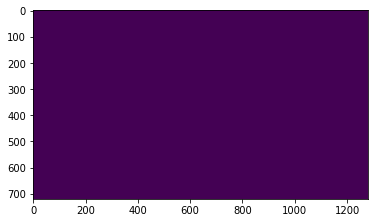

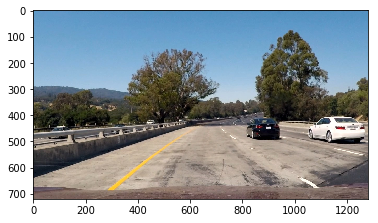

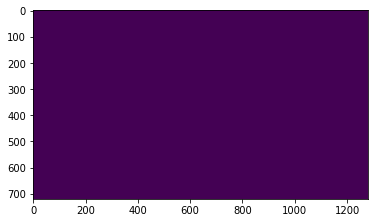

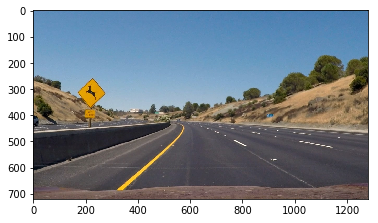

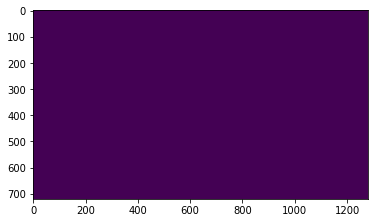

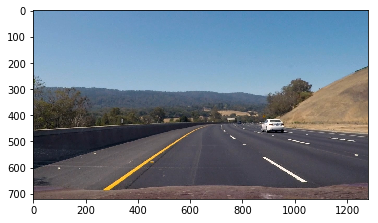

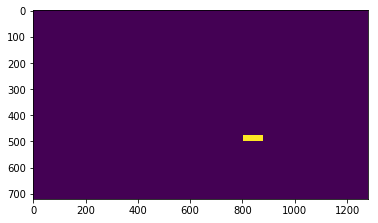

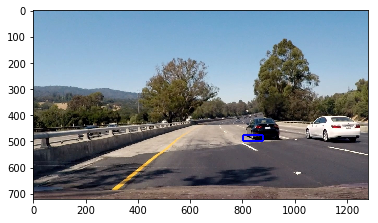

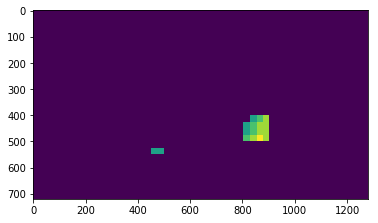

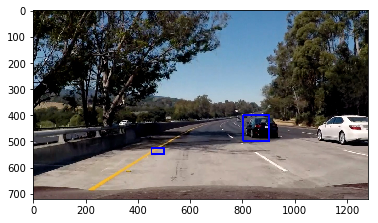

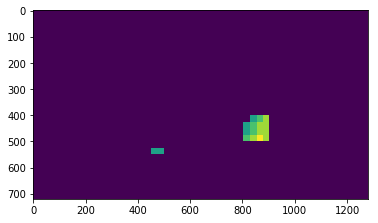

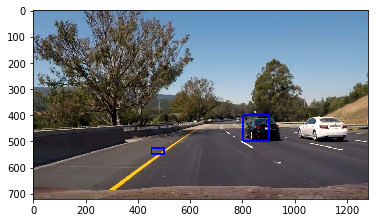

In [75]:
#### Test the Model on the TEST Images
from scipy.ndimage.measurements import label
from scipy.ndimage import minimum_position, maximum_position, center_of_mass

%matplotlib inline

## Load the Saved Model from Disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = pickle.load(open(filename, 'rb'))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]


# Read in test images
test_images = glob.glob('test_images/*.jpg')

print("# of test_images", len(test_images))

for testimage in test_images:
    image = mpimg.imread(testimage)
    #plt.imshow(image)
    #plt.show()
    final_img = process_image(image)
    plt.imshow(final_img)
    plt.show()
    
    

In [80]:
# Car Detection on Video now #
from moviepy.editor import VideoFileClip
from moviepy.video.VideoClip import VideoClip
from IPython.display import HTML


## Load the Saved Model from Disk
filename = 'final_SVCmodel_pickle.pkl'
dist_pickle = pickle.load(open(filename, 'rb'))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]


Input_video = 'project_video.mp4'
#Input_video = 'test_video.mp4'
video_output = 'Output_project_video_test.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)



[MoviePy] >>>> Building video Output_project_video_test.mp4
[MoviePy] Writing video Output_project_video_test.mp4



 12%|█▏        | 152/1261 [02:02<15:06,  1.22it/s]


 24%|██▍       | 303/1261 [04:03<12:12,  1.31it/s]


 36%|███▌      | 454/1261 [06:02<11:11,  1.20it/s]


 48%|████▊     | 605/1261 [08:38<10:08,  1.08it/s]


 60%|█████▉    | 756/1261 [10:54<07:34,  1.11it/s]


 72%|███████▏  | 907/1261 [13:08<05:16,  1.12it/s]


 84%|████████▍ | 1057/1261 [15:22<03:03,  1.11it/s]


 96%|█████████▌| 1205/1261 [17:33<00:48,  1.16it/s]


100%|█████████▉| 1260/1261 [18:21<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_project_video_test.mp4 



In [72]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("project_video.mp4", 0, 10, targetname="test(0-10).mp4")


[MoviePy] Running:
>>> /Users/sarvagyagupta/Library/Application Support/imageio/ffmpeg/ffmpeg.osx -y -i project_video.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy test(0-10).mp4
... command successful.


In [20]:
#video_output = 'Output_project_video.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))